<a href="https://colab.research.google.com/github/samer-glitch/Predicting-Diabetes-and-Assessing-Risk-levels-for-retinopathy-disease-Using-ML/blob/main/ML%20for%20Diabetes%20Prediction%20and%20RetinoPathy%20Disease%20Risk%20Categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv


In [2]:
import pandas as pd

# Load the dataset to perform EDA
data_path = 'diabetes_prediction_dataset.csv'
diabetes_data = pd.read_csv(data_path)

# Display the first few rows of the dataset to understand its structure
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
print("Shape before removing duplicates:", diabetes_data.shape)
diabetes_data_cleaned = diabetes_data.drop_duplicates()
print("Shape after removing duplicates:", diabetes_data_cleaned.shape)
print("Rows removed:", diabetes_data.shape[0] - diabetes_data_cleaned.shape[0])


Shape before removing duplicates: (100000, 9)
Shape after removing duplicates: (96146, 9)
Rows removed: 3854


In [4]:
# Check for NaN values in the target variable 'diabetes'
print("Number of NaN values in 'diabetes' column:", diabetes_data_cleaned['diabetes'].isna().sum())
# Re-check the entire dataframe for NaN values
print(diabetes_data_cleaned.isna().sum())

Number of NaN values in 'diabetes' column: 0
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [5]:
# Check data types for all columns
print(diabetes_data_cleaned.dtypes)

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [6]:
# Check for NaN values in the target variable 'diabetes'
nan_values_in_y = diabetes_data_cleaned['diabetes'].isnull().sum()
nan_values_in_y
# Drop rows with NaN values in the target variable 'diabetes'
diabetes_data_cleaned = diabetes_data.dropna(subset=['diabetes'])

# Check the shape of the cleaned dataset
diabetes_data_cleaned.shape


(100000, 9)

Loading data...
Cleaning data...
Shape after cleaning and removing duplicates: (96146, 9)
Checking categorical variables for NaNs...
Encoding categorical variables...
NaN values found after encoding. Cleaning further...
Preparing data for modeling...
Splitting data...
Applying SMOTE...
Applying StandardScaler...
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Tuning hyperparameters for Neural Network...
Best parameters for Neural Network: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}
Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01}


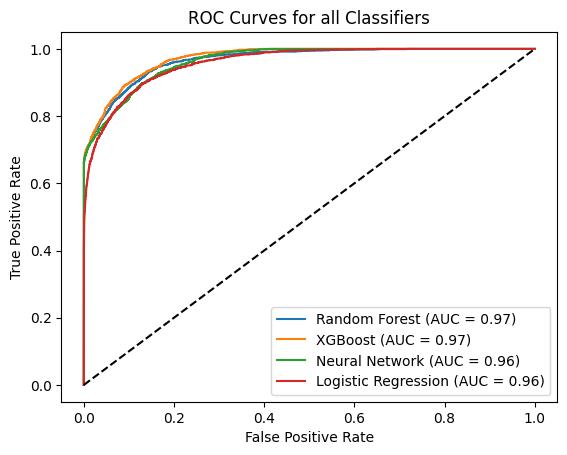

,Classifier,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Running Time (s)
0,Random Forest,0.968401,0.933665,0.690374,0.793796,0.967559,301.680220
1,XGBoost,0.970399,0.977935,0.679338,0.801737,0.972668,5.812641
2,Neural Network,0.959650,0.798246,0.725322,0.760039,0.964871,3317.944798
3,Logistic Regression,0.884568,0.424792,0.876150,0.572172,0.959088,3.488548


In [7]:
# part 1 : applying ML techniques on the dataset (cleaned and processed) using SMOT technique for class imbalance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from IPython.display import display

# Load the cleaned dataset
print("Loading data...")
diabetes_data = pd.read_csv("diabetes_prediction_dataset.csv")

# Drop rows with any NaN values in the dataset and remove duplicates
print("Cleaning data...")
diabetes_data_cleaned = diabetes_data.dropna().drop_duplicates()
print("Shape after cleaning and removing duplicates:", diabetes_data_cleaned.shape)

# Explicitly ensure no NaN values in categorical variables before encoding
print("Checking categorical variables for NaNs...")
if diabetes_data_cleaned[['gender', 'smoking_history']].isnull().any().any():
    diabetes_data_cleaned[['gender', 'smoking_history']] = diabetes_data_cleaned[['gender', 'smoking_history']].fillna('Unknown')

# One-hot encode categorical variables
print("Encoding categorical variables...")
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(diabetes_data_cleaned[['gender', 'smoking_history']])
encoded_feature_names = encoder.get_feature_names_out(['gender', 'smoking_history'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Merge encoded features back to the dataset
diabetes_data_encoded = pd.concat([diabetes_data_cleaned.drop(['gender', 'smoking_history'], axis=1), encoded_df], axis=1)

# Ensure there are no NaN values after encoding and merging
if diabetes_data_encoded.isnull().any().any():
    print("NaN values found after encoding. Cleaning further...")
    diabetes_data_encoded.dropna(inplace=True)

# Ensure the 'diabetes' column is clean before conversion
if diabetes_data_encoded['diabetes'].isnull().any():
    print("NaN values found in 'diabetes'. Cleaning further...")
    diabetes_data_encoded = diabetes_data_encoded.dropna(subset=['diabetes'])

print("Preparing data for modeling...")
X = diabetes_data_encoded.drop('diabetes', axis=1)
y = diabetes_data_encoded['diabetes'].astype(int)  # Safe to convert after NaN check

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Applying StandardScaler...")
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Network': MLPClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [100], 'max_depth': [4], 'learning_rate': [0.1]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 50)], 'alpha': [0.001, 0.01]},
    'Logistic Regression': {'C': [0.001, 0.01]}
}

# Cross-validation and hyperparameter tuning using StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, clf in classifiers.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv_strategy, scoring='roc_auc')
    start_time = time()
    grid_search.fit(X_train_smote_scaled, y_train_smote)
    best_clf = grid_search.best_estimator_
    end_time = time()
    running_time = end_time - start_time
    print(f"Best parameters for {name}: {grid_search.best_params_}")

    # Metrics
    y_pred = best_clf.predict(X_test_scaled)
    y_probas = best_clf.predict_proba(X_test_scaled)[:, 1]
    results.append({
        'Classifier': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_probas),
        'Running Time (s)': running_time
    })

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probas)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_probas):.2f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for all Classifiers')
plt.legend(loc="lower right")
plt.show()

# Display model performance summary
performance_df = pd.DataFrame(results)
display(performance_df)


Loading data...
Cleaning data...
Shape after cleaning and removing duplicates: (96146, 9)
Checking categorical variables for NaNs...
Encoding categorical variables...
NaN values found after encoding. Cleaning further...
Preparing data for modeling...
Splitting data...
Applying ADASYN...
Applying StandardScaler...
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Tuning hyperparameters for Neural Network...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for Neural Network: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50)}
Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01}


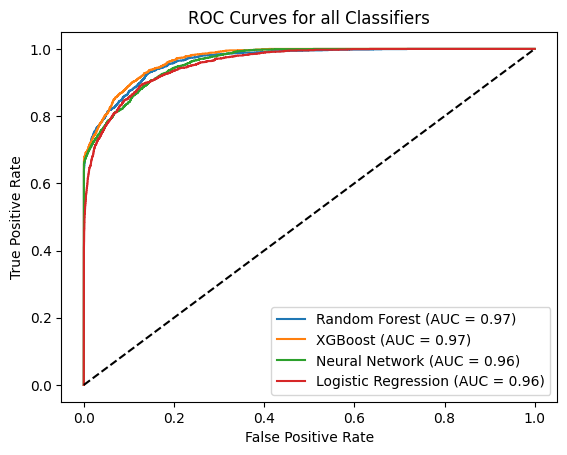

,Classifier,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Running Time (s)
0,Random Forest,0.964025,0.863055,0.703250,0.775000,0.966764,330.501986
1,XGBoost,0.966186,0.895981,0.697118,0.784138,0.971217,5.990814
2,Neural Network,0.945930,0.673841,0.748620,0.709265,0.962576,3595.085286
3,Logistic Regression,0.835629,0.340054,0.920294,0.496609,0.957930,2.282274


In [8]:
# part 1 : applying ML techniques on the dataset (cleaned and processed) using ADASYN technique for class imbalance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from IPython.display import display

# Load the cleaned dataset
print("Loading data...")
diabetes_data = pd.read_csv("diabetes_prediction_dataset.csv")

# Drop rows with any NaN values in the dataset and remove duplicates
print("Cleaning data...")
diabetes_data_cleaned = diabetes_data.dropna().drop_duplicates()
print("Shape after cleaning and removing duplicates:", diabetes_data_cleaned.shape)

# Explicitly ensure no NaN values in categorical variables before encoding
print("Checking categorical variables for NaNs...")
if diabetes_data_cleaned[['gender', 'smoking_history']].isnull().any().any():
    diabetes_data_cleaned[['gender', 'smoking_history']] = diabetes_data_cleaned[['gender', 'smoking_history']].fillna('Unknown')

# One-hot encode categorical variables
print("Encoding categorical variables...")
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(diabetes_data_cleaned[['gender', 'smoking_history']])
encoded_feature_names = encoder.get_feature_names_out(['gender', 'smoking_history'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Merge encoded features back to the dataset
diabetes_data_encoded = pd.concat([diabetes_data_cleaned.drop(['gender', 'smoking_history'], axis=1), encoded_df], axis=1)

# Ensure there are no NaN values after encoding and merging
if diabetes_data_encoded.isnull().any().any():
    print("NaN values found after encoding. Cleaning further...")
    diabetes_data_encoded.dropna(inplace=True)

print("Preparing data for modeling...")
X = diabetes_data_encoded.drop('diabetes', axis=1)
y = diabetes_data_encoded['diabetes'].astype(int)  # Safe to convert after NaN check

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Applying ADASYN...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print("Applying StandardScaler...")
scaler = StandardScaler()
X_train_adasyn_scaled = scaler.fit_transform(X_train_adasyn)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Network': MLPClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [100], 'max_depth': [4], 'learning_rate': [0.1]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 50)], 'alpha': [0.001, 0.01]},
    'Logistic Regression': {'C': [0.001, 0.01]}
}

# Cross-validation and hyperparameter tuning using StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, clf in classifiers.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv_strategy, scoring='roc_auc')
    start_time = time()
    grid_search.fit(X_train_adasyn_scaled, y_train_adasyn)
    best_clf = grid_search.best_estimator_
    end_time = time()
    running_time = end_time - start_time
    print(f"Best parameters for {name}: {grid_search.best_params_}")

    # Metrics
    y_pred = best_clf.predict(X_test_scaled)
    y_probas = best_clf.predict_proba(X_test_scaled)[:, 1]
    results.append({
        'Classifier': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_probas),
        'Running Time (s)': running_time
    })

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probas)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_probas):.2f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for all Classifiers')
plt.legend(loc="lower right")
plt.show()

# Display model performance summary
performance_df = pd.DataFrame(results)
display(performance_df)


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the cleaned dataset
print("Loading data...")
diabetes_data = pd.read_csv("diabetes_prediction_dataset.csv")

# Drop rows with any NaN values in the dataset and remove duplicates
print("Cleaning data...")
diabetes_data_cleaned = diabetes_data.dropna().drop_duplicates()
print(f"Shape after cleaning and removing duplicates: {diabetes_data_cleaned.shape}")

# One-hot encode categorical variables
print("Encoding categorical variables...")
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(diabetes_data_cleaned[['gender', 'smoking_history']])
encoded_feature_names = encoder.get_feature_names_out(['gender', 'smoking_history'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Merge encoded features back to the dataset
diabetes_data_encoded = pd.concat([diabetes_data_cleaned.drop(['gender', 'smoking_history'], axis=1), encoded_df], axis=1)
print(f"Shape after encoding and merging: {diabetes_data_encoded.shape}")

# Ensure there are no NaN values after encoding and merging
if diabetes_data_encoded.isnull().any().any():
    print("NaN values found after encoding. Cleaning further...")
    diabetes_data_encoded.dropna(inplace=True)
print(f"Shape after dropping NaNs: {diabetes_data_encoded.shape}")

# Preparing data for modeling
X = diabetes_data_encoded.drop('diabetes', axis=1)
y = diabetes_data_encoded['diabetes'].astype(int)  # Ensure type conversion after NaN check
print(f"Shapes of X and y: {X.shape}, {y.shape}")

# Splitting data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shapes after split - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


Loading data...
Cleaning data...
Shape after cleaning and removing duplicates: (96146, 9)
Encoding categorical variables...
Shape after encoding and merging: (99731, 16)
NaN values found after encoding. Cleaning further...
Shape after dropping NaNs: (92561, 16)
Shapes of X and y: (92561, 15), (92561,)
Splitting data...
Shapes after split - X_train: (74048, 15), X_test: (18513, 15), y_train: (74048,), y_test: (18513,)


In [10]:
diabetes_data_encoded.head(200)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0.0,1.0,25.19,6.6,140.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0.0,0.0,27.32,6.6,80.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0.0,0.0,27.32,5.7,158.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0.0,0.0,23.45,5.0,155.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1.0,1.0,20.14,4.8,155.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,45.0,0.0,0.0,42.24,6.1,130.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196,80.0,0.0,0.0,27.32,6.0,140.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
197,76.0,0.0,0.0,23.93,5.8,130.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
198,3.0,0.0,0.0,15.48,5.7,130.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Loading data...
Cleaning data...
Shape after cleaning and removing duplicates: (96146, 9)
Encoding categorical variables...
Shape after encoding and merging: (99731, 16)
NaN values found after encoding. Cleaning further...
Shape after dropping NaNs: (92561, 16)
Shapes of X and y: (92561, 15), (92561,)
Splitting data...
Shapes after split - X_train: (74048, 15), X_test: (18513, 15), y_train: (74048,), y_test: (18513,)
Applying SMOTE...
Applying StandardScaler...
Training Random Forest...
Training XGBoost...
Training Neural Network...
Training Logistic Regression...


,Classifier,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Running Time (s)
0,Random Forest,0.967914,0.935108,0.685366,0.790992,0.970387,25.109183
1,XGBoost,0.969427,0.965338,0.679268,0.797423,0.975665,1.078256
2,Neural Network,0.951710,0.717620,0.750000,0.733453,0.970696,66.130547
3,Logistic Regression,0.885540,0.428272,0.871951,0.574413,0.959371,0.280888


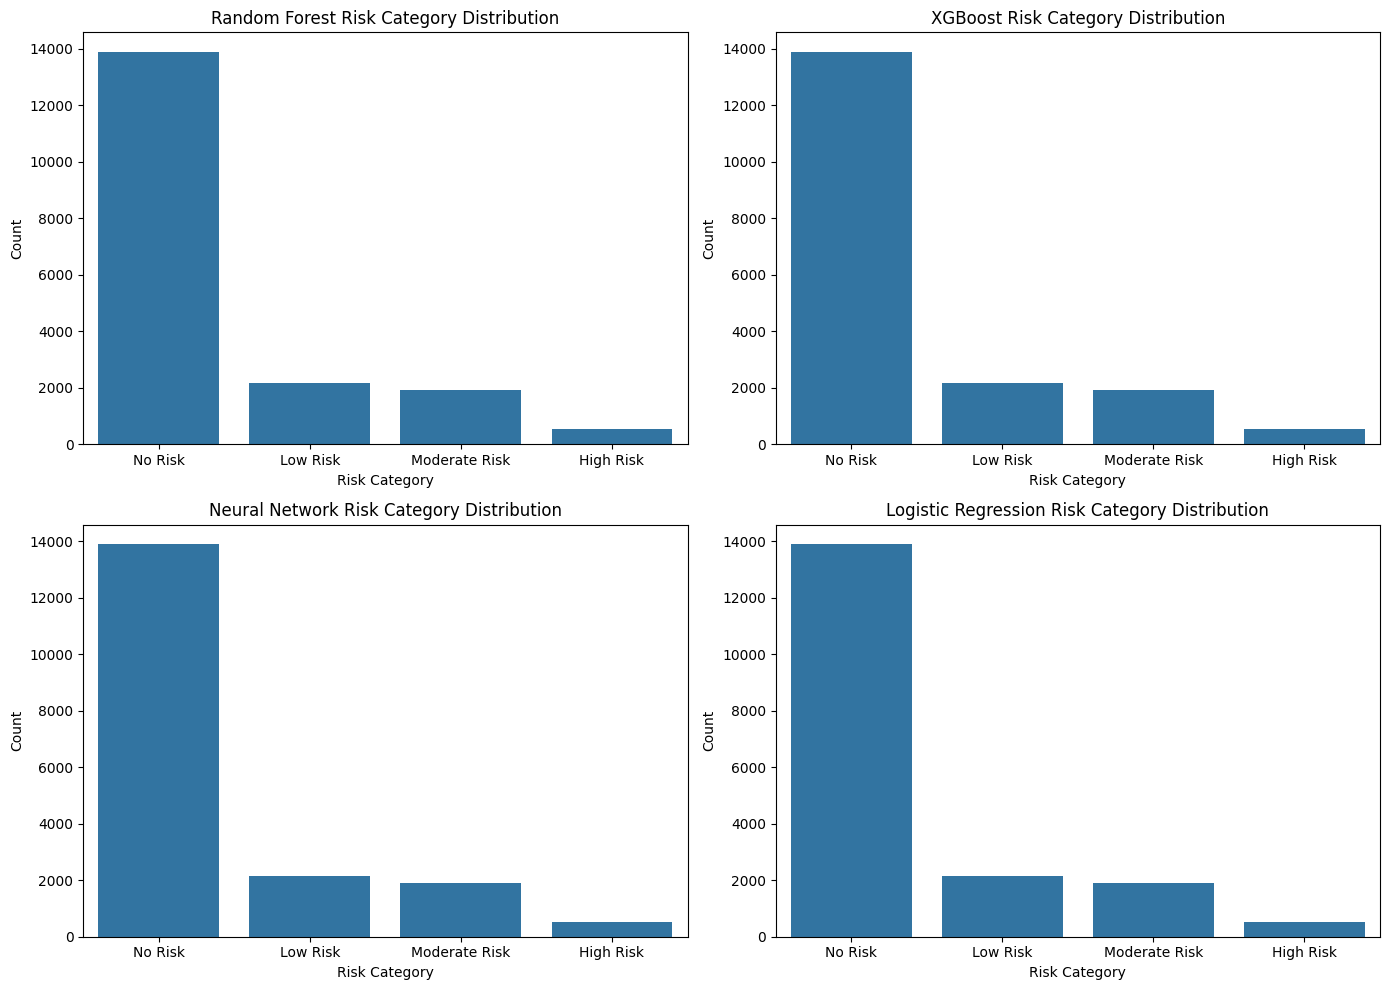

In [18]:
# same as before using SMOT but for showing the Retino pathy disease risk assessment on testing data =  20% of the cleaned dataset from orignial data ON different
# ML learning techniques we used with best Hyperparameter tuning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns


def risk_scoring(row):
    score = 0
    if row['HbA1c_level'] <= 7:
        score += 0
    elif 7 < row['HbA1c_level'] <= 8:
        score += 1
    elif 8 < row['HbA1c_level'] <= 9:
        score += 2
    elif row['HbA1c_level'] > 9:
        score += 3
    if row['hypertension'] == 1:
        score += 1
    if row['heart_disease'] == 1:
        score += 2
    if row['bmi'] < 25:
        score += 0
    elif 25 <= row['bmi'] < 30:
        score += 1
    elif row['bmi'] >= 30:
        score += 2
    if row['age'] < 40:
        score += 0
    elif 40 <= row['age'] < 50:
        score += 1
    elif 50 <= row['age'] < 60:
        score += 2
    elif row['age'] >= 60:
        score += 3
    # Scoring rule for smoking_history
    if 'smoking_history' in row:
        if row['smoking_history'] == 'never':
            score += 0
        elif row['smoking_history'] == 'ever':
            score += 1
        elif row['smoking_history'] == 'former':
            score += 2
        elif row['smoking_history'] == 'current':
            score += 3
        elif row['smoking_history'] == 'not current':
            score += 1
        elif row['smoking_history'] == 'No Info':
            score += 0

    # Scoring rule for gender
    if 'gender' in row:
        if row['gender'] == 'Male':
            score += 1
        elif row['gender'] == 'Female':
            score += 2
        elif row['gender'] == 'Other':
            score += 0

    # Scoring rule for blood_glucose_level
    if 'blood_glucose_level' in row:
        if row['blood_glucose_level'] < 100:
            score += 0
        elif 100 <= row['blood_glucose_level'] < 126:
            score += 1
        elif 126 <= row['blood_glucose_level'] < 200:
            score += 2
        elif row['blood_glucose_level'] >= 200:
            score += 3
    return score

# Load the cleaned dataset
print("Loading data...")
diabetes_data = pd.read_csv("diabetes_prediction_dataset.csv")

# Drop rows with any NaN values in the dataset and remove duplicates
print("Cleaning data...")
diabetes_data_cleaned = diabetes_data.dropna().drop_duplicates()
print(f"Shape after cleaning and removing duplicates: {diabetes_data_cleaned.shape}")

# One-hot encode categorical variables
print("Encoding categorical variables...")
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(diabetes_data_cleaned[['gender', 'smoking_history']])
encoded_feature_names = encoder.get_feature_names_out(['gender', 'smoking_history'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Merge encoded features back to the dataset
diabetes_data_encoded = pd.concat([diabetes_data_cleaned.drop(['gender', 'smoking_history'], axis=1), encoded_df], axis=1)
print(f"Shape after encoding and merging: {diabetes_data_encoded.shape}")

# Ensure there are no NaN values after encoding and merging
if diabetes_data_encoded.isnull().any().any():
    print("NaN values found after encoding. Cleaning further...")
    diabetes_data_encoded.dropna(inplace=True)
print(f"Shape after dropping NaNs: {diabetes_data_encoded.shape}")

# Preparing data for modeling
X = diabetes_data_encoded.drop('diabetes', axis=1)
y = diabetes_data_encoded['diabetes'].astype(int)  # Ensure type conversion after NaN check
print(f"Shapes of X and y: {X.shape}, {y.shape}")

# Splitting data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shapes after split - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

# Apply SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply StandardScaler
print("Applying StandardScaler...")
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Define classifiers with the best parameters from part 1
classifiers = {
    'Random Forest': RandomForestClassifier(max_depth=20, n_estimators=200),
    'XGBoost': XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100),
    'Neural Network': MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50)),
    'Logistic Regression': LogisticRegression(C=0.01)
}

# Fit models, predict, and calculate risks
results = []
for name, clf in classifiers.items():
    print(f"Training {name}...")
    start_time = time()
    clf.fit(X_train_smote_scaled, y_train_smote)
    end_time = time()

    # Prediction and probabilities
    y_pred = clf.predict(X_test_scaled)
    y_probas = clf.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probas)
    running_time = end_time - start_time

    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'Running Time (s)': running_time
    })

    # Assign predictions, risk scores, and categories to the test set part of the dataframe
    test_indices = X_test.index
    diabetes_data_encoded.loc[test_indices, f'{name}_Prediction'] = y_pred
    diabetes_data_encoded.loc[test_indices, f'{name}_Risk_Score'] = diabetes_data_encoded.loc[test_indices].apply(risk_scoring, axis=1)
    diabetes_data_encoded.loc[test_indices, f'{name}_Risk_Category'] = diabetes_data_encoded.loc[test_indices, f'{name}_Risk_Score'].apply(
        lambda x: 'High Risk' if x >= 9 else 'Moderate Risk' if x >= 7 else 'Low Risk' if x > 5 else 'No Risk'
    )

# Display model performance summary
performance_df = pd.DataFrame(results)
display(performance_df)

# Visualization of Risk Categories for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for idx, (name, _) in enumerate(classifiers.items()):
    sns.countplot(x=f'{name}_Risk_Category', data=diabetes_data_encoded.loc[test_indices], ax=axes[idx])
    axes[idx].set_title(f'{name} Risk Category Distribution')
    axes[idx].set_xlabel('Risk Category')
    axes[idx].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

# Assuming that 'diabetes_data_encoded' is a pandas DataFrame
df = diabetes_data_encoded

# Count the non-NaN values in the 'Random Forest_Risk_Category' column
non_nan_count = df['Random Forest_Risk_Category'].count()

# Get the total number of rows in the DataFrame
total_rows = len(df)

# Calculate the percentage of non-NaN values
percentage = (non_nan_count / total_rows) * 100

print(f"Number of non-NaN values in 'Random Forest_Risk_Category': {non_nan_count}")
print(f"Percentage of non-NaN values: {percentage}%")

Number of non-NaN values in 'Random Forest_Risk_Category': 18513
Percentage of non-NaN values: 20.00086429489742%


In [19]:
diabetes_data_encoded.head(50)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,...,Random Forest_Risk_Category,XGBoost_Prediction,XGBoost_Risk_Score,XGBoost_Risk_Category,Neural Network_Prediction,Neural Network_Risk_Score,Neural Network_Risk_Category,Logistic Regression_Prediction,Logistic Regression_Risk_Score,Logistic Regression_Risk_Category
0,80.0,0.0,1.0,25.19,6.6,140.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54.0,0.0,0.0,27.32,6.6,80.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28.0,0.0,0.0,27.32,5.7,158.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36.0,0.0,0.0,23.45,5.0,155.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76.0,1.0,1.0,20.14,4.8,155.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20.0,0.0,0.0,27.32,6.6,85.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,44.0,0.0,0.0,19.31,6.5,200.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,79.0,0.0,0.0,23.86,5.7,85.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,42.0,0.0,0.0,33.64,4.8,145.0,0.0,0.0,1.0,0.0,...,No Risk,0.0,5.0,No Risk,0.0,5.0,No Risk,0.0,5.0,No Risk
9,32.0,0.0,0.0,27.32,5.0,100.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv


Loading and preparing the historical data...
One-hot encoding categorical variables...
Checking and handling any remaining NaNs before applying SMOTE...
Applying SMOTE and scaling...
Defining classifiers with optimized parameters...
Training classifiers on the historical data...
Training Random Forest...
Training XGBoost...
Training Neural Network...
Training Logistic Regression...
Loading new data and applying the same preprocessing...
Applying the same StandardScaler to the new data...
Predicting and assessing risk on new data...
Predicting with Random Forest...
Predicting with XGBoost...
Predicting with Neural Network...
Predicting with Logistic Regression...
Visualizing the risk category distribution...


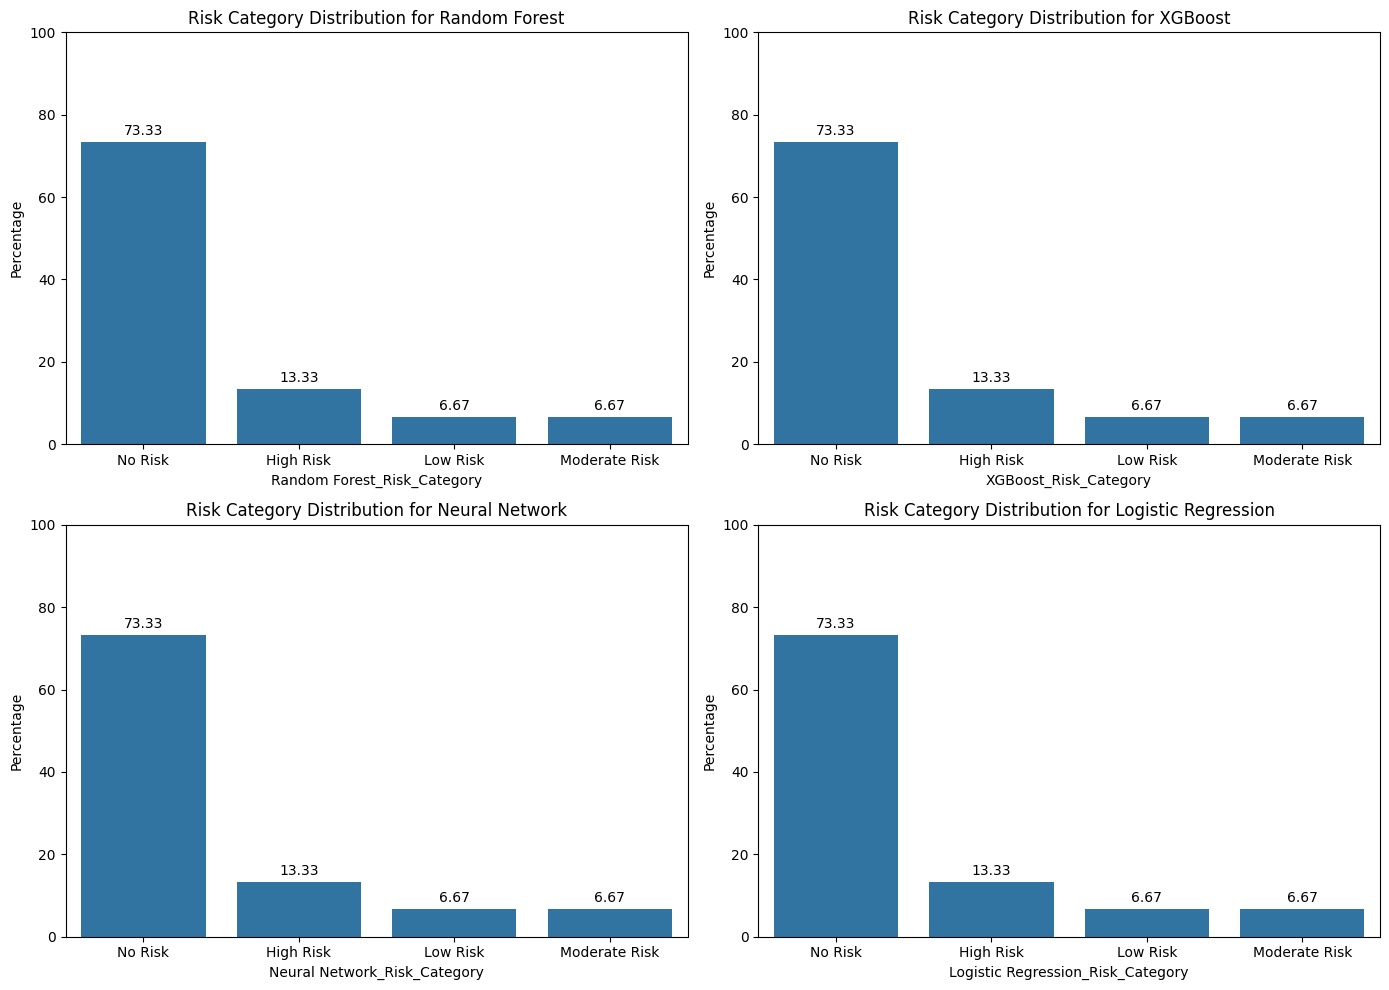

In [24]:
# Final optimized part 2
# part 2 FINALIZED
# This code includes all the steps you mentioned: loading and preprocessing the data, training the classifiers,
# loading and preprocessing new data, making predictions with the trained classifiers, calculating risk scores and categories, and visualizing the results.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from time import time

def risk_scoring(row):
    score = 0
    if row['HbA1c_level'] <= 7:
        score += 0
    elif 7 < row['HbA1c_level'] <= 8:
        score += 1
    elif 8 < row['HbA1c_level'] <= 9:
        score += 2
    elif row['HbA1c_level'] > 9:
        score += 3
    if row['hypertension'] == 1:
        score += 1
    if row['heart_disease'] == 1:
        score += 2
    if row['bmi'] < 25:
        score += 0
    elif 25 <= row['bmi'] < 30:
        score += 1
    elif row['bmi'] >= 30:
        score += 2
    if row['age'] < 40:
        score += 0
    elif 40 <= row['age'] < 50:
        score += 1
    elif 50 <= row['age'] < 60:
        score += 2
    elif row['age'] >= 60:
        score += 3
    # Scoring rule for smoking_history
    if 'smoking_history' in row:
        if row['smoking_history'] == 'never':
            score += 0
        elif row['smoking_history'] == 'ever':
            score += 1
        elif row['smoking_history'] == 'former':
            score += 2
        elif row['smoking_history'] == 'current':
            score += 3
        elif row['smoking_history'] == 'not current':
            score += 1
        elif row['smoking_history'] == 'No Info':
            score += 0

    # Scoring rule for gender
    if 'gender' in row:
        if row['gender'] == 'Male':
            score += 1
        elif row['gender'] == 'Female':
            score += 2
        elif row['gender'] == 'Other':
            score += 0

    # Scoring rule for blood_glucose_level
    if 'blood_glucose_level' in row:
        if row['blood_glucose_level'] < 100:
            score += 0
        elif 100 <= row['blood_glucose_level'] < 126:
            score += 1
        elif 126 <= row['blood_glucose_level'] < 200:
            score += 2
        elif row['blood_glucose_level'] >= 200:
            score += 3
    return score

# Define the risk categorization function
#def risk_categorization(score):
#    if score <= 3:
#        return 'Low'
#    elif 3 < score <= 6:
#        return 'Medium'
#    else:
#        return 'High'



# Load and prepare the historical data
print("Loading and preparing the historical data...")
data = pd.read_csv("diabetes_prediction_dataset.csv")
data_cleaned = data.dropna().drop_duplicates()

# One-hot encode categorical variables
print("One-hot encoding categorical variables...")
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(data_cleaned[['gender', 'smoking_history']]).toarray(),
                         columns=encoder.get_feature_names_out(['gender', 'smoking_history']))
X = pd.concat([data_cleaned.drop(['gender', 'smoking_history', 'diabetes'], axis=1).reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)
y = data_cleaned['diabetes'].astype(int).reset_index(drop=True)

# Check and handle any remaining NaNs before applying SMOTE
print("Checking and handling any remaining NaNs before applying SMOTE...")
X.fillna(X.mean(), inplace=True)  # Imputing with the mean (or choose another method suitable for your data)

# Apply SMOTE and scaling
print("Applying SMOTE and scaling...")
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote)

# Define classifiers with optimized parameters
print("Defining classifiers with optimized parameters...")
classifiers = {
    'Random Forest': RandomForestClassifier(max_depth=20, n_estimators=200),
    'XGBoost': XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100),
    'Neural Network': MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50)),
    'Logistic Regression': LogisticRegression(C=0.01)
}

# Train classifiers on the historical data
print("Training classifiers on the historical data...")
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_smote_scaled, y_smote)

# Load new data and apply the same preprocessing
print("Loading new data and applying the same preprocessing...")
new_data = pd.read_csv("new_dataset.csv")

# Check if 'gender' and 'smoking_history' columns exist in the new data
if 'gender' in new_data.columns and 'smoking_history' in new_data.columns:
    new_data_encoded = pd.DataFrame(encoder.transform(new_data[['gender', 'smoking_history']]).toarray(),
                                    columns=encoder.get_feature_names_out(['gender', 'smoking_history']))
    new_data_final = pd.concat([new_data.drop(['gender', 'smoking_history'], axis=1), new_data_encoded], axis=1)
else:
    new_data_final = new_data.copy()

# Apply the same StandardScaler to the new data
print("Applying the same StandardScaler to the new data...")
if 'diabetes' in new_data_final.columns:
    X_new_scaled = scaler.transform(new_data_final.drop(['diabetes'], axis=1))
else:
    X_new_scaled = scaler.transform(new_data_final)

# Predict and assess risk on new data
print("Predicting and assessing risk on new data...")
for name, clf in classifiers.items():
    print(f"Predicting with {name}...")
    new_data_final[f'{name}_Prediction'] = clf.predict(X_new_scaled)
    new_data_final[f'{name}_Risk_Score'] = new_data_final.apply(risk_scoring, axis=1)
    new_data_final[f'{name}_Risk_Category'] = new_data_final[f'{name}_Risk_Score'].apply(
        lambda score: 'High Risk' if score >= 9 else 'Moderate Risk' if score >= 7 else 'Low Risk' if score > 5 else 'No Risk')

# Visualization of the risk category distribution
print("Visualizing the risk category distribution...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, name in enumerate(classifiers.keys()):
    risk_counts = new_data_final[f'{name}_Risk_Category'].value_counts(normalize=True) * 100
    sns.barplot(x=risk_counts.index, y=risk_counts.values, ax=axes[i])
    axes[i].set_title(f'Risk Category Distribution for {name}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    for bar in axes[i].patches:
        axes[i].annotate(format(bar.get_height(), '.2f'),
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         ha='center', va='center',
                         size=10, xytext=(0, 8),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [25]:
new_data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,90,1,1,never,35.00,8.0,250,NaN
1,Female,24,0,0,No Info,27.32,6.6,80,NaN
2,Male,37,0,0,never,44.00,7.0,230,NaN
3,Female,44,1,1,current,23.45,5.0,155,NaN
4,Male,30,0,0,never,23.00,6.0,100,NaN
5,Female,26,0,0,No Info,20.00,5.0,80,NaN
6,Female,27,1,0,former,33.00,6.0,130,NaN
7,Female,33,0,0,never,23.00,5.0,120,NaN
8,Female,36,0,0,never,16.00,6.0,80,NaN
9,Female,39,0,1,current,30.00,7.5,260,NaN


In [26]:
new_data_final

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,...,Random Forest_Risk_Category,XGBoost_Prediction,XGBoost_Risk_Score,XGBoost_Risk_Category,Neural Network_Prediction,Neural Network_Risk_Score,Neural Network_Risk_Category,Logistic Regression_Prediction,Logistic Regression_Risk_Score,Logistic Regression_Risk_Category
0,90,1,1,35.00,8.0,250,NaN,1.0,0.0,0.0,...,High Risk,1,12,High Risk,1,12,High Risk,1,12,High Risk
1,24,0,0,27.32,6.6,80,NaN,1.0,0.0,0.0,...,No Risk,0,1,No Risk,0,1,No Risk,0,1,No Risk
2,37,0,0,44.00,7.0,230,NaN,0.0,1.0,0.0,...,No Risk,1,5,No Risk,1,5,No Risk,1,5,No Risk
3,44,1,1,23.45,5.0,155,NaN,1.0,0.0,0.0,...,Low Risk,0,6,Low Risk,0,6,Low Risk,0,6,Low Risk
4,30,0,0,23.00,6.0,100,NaN,0.0,1.0,0.0,...,No Risk,0,1,No Risk,0,1,No Risk,0,1,No Risk
5,26,0,0,20.00,5.0,80,NaN,1.0,0.0,0.0,...,No Risk,0,0,No Risk,0,0,No Risk,0,0,No Risk
6,27,1,0,33.00,6.0,130,NaN,1.0,0.0,0.0,...,No Risk,0,5,No Risk,0,5,No Risk,0,5,No Risk
7,33,0,0,23.00,5.0,120,NaN,1.0,0.0,0.0,...,No Risk,0,1,No Risk,0,1,No Risk,0,1,No Risk
8,36,0,0,16.00,6.0,80,NaN,1.0,0.0,0.0,...,No Risk,0,0,No Risk,0,0,No Risk,0,0,No Risk
9,39,0,1,30.00,7.5,260,NaN,1.0,0.0,0.0,...,Moderate Risk,1,8,Moderate Risk,1,8,Moderate Risk,1,8,Moderate Risk


In [ ]:
# END OF CODING